In [ ]:
# !pip install optuna
# import optuna
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_absolute_error
import math
import seaborn as sns
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.utils.data as utils
import time
import torch.optim as optim

In [ ]:
data = pd.read_csv("ISAT.csv",parse_dates=['Date'])
data = data.set_index('Date')
data = data[ :'2021-09-24']
data = data.dropna().reset_index()
data = data.set_index('Date')
# data = data[:22]

In [ ]:
price = data[['Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#Create Sequence Data

In [ ]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])

    data = np.array(data);
    test_set_size = int(30);
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [ ]:
lookback = 21 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [ ]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
x_train.shape, x_test.shape, y_test.shape

(torch.Size([4301, 20, 1]), torch.Size([30, 20, 1]), torch.Size([30, 1]))

#Build Model

In [ ]:
class RNN(nn.Module):
  
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, h0 = self.rnn(x, h0.detach())
        out = out[:, -1, :]
        out = self.linear(out)
        return out

In [ ]:
class LSTM(nn.Module):
  
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :]
        out = self.linear(out)
        return out

In [ ]:
class BiLSTM(nn.Module):
  
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional = True)
        self.linear = nn.Linear(2*hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :]
        out = self.linear(out)
        return out

In [ ]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean((np.abs(Y_Predicted-Y_actual)/Y_actual))*100
    return mape

#Train Model Using Best Parameter

##Train RNN

In [ ]:
rnn = RNN(input_dim=1, hidden_dim=32, output_dim=1, num_layers=2)
criterion = torch.nn.L1Loss(reduction='mean')
optimiser = torch.optim.Adam(rnn.parameters(), lr=0.001)

In [ ]:
import time
num_epochs = 300
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    y_train_pred = rnn(x_train)
    loss = criterion(y_train_pred, y_train)
    if t%50==0 or t==299:
      print("Epoch ", t, "MAE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch  0 MAE:  0.7061988711357117
Epoch  50 MAE:  0.09780728071928024
Epoch  100 MAE:  0.01620156690478325
Epoch  150 MAE:  0.015925945714116096
Epoch  200 MAE:  0.013858284801244736
Epoch  250 MAE:  0.013061055913567543
Epoch  299 MAE:  0.012699771672487259


##Train LSTM

In [ ]:
lstm = LSTM(input_dim=1, hidden_dim=32, output_dim=1, num_layers=2)
criterion = torch.nn.L1Loss(reduction='mean')
optimiser = torch.optim.Adam(lstm.parameters(), lr=0.001)

In [ ]:
import time
num_epochs = 300
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    y_train_pred = lstm(x_train)
    loss = criterion(y_train_pred, y_train)
    if t%50==0 or t==299:
      print("Epoch ", t, "MAE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch  0 MAE:  0.24682600796222687
Epoch  50 MAE:  0.1026255190372467
Epoch  100 MAE:  0.025254758074879646
Epoch  150 MAE:  0.02108539082109928
Epoch  200 MAE:  0.018331635743379593
Epoch  250 MAE:  0.016648203134536743
Epoch  299 MAE:  0.015855373814702034


##Train BiLSTM

In [ ]:
bilstm = BiLSTM(input_dim=1, hidden_dim=32, output_dim=1, num_layers=2)
criterion = torch.nn.L1Loss(reduction='mean')
optimiser = torch.optim.Adam(bilstm.parameters(), lr=0.001)

In [ ]:
import time
num_epochs = 300
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    y_train_pred = bilstm(x_train)
    loss = criterion(y_train_pred, y_train)
    if t%50==0 or t==299:
      print("Epoch ", t, "MAE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch  0 MAE:  0.44828465580940247
Epoch  50 MAE:  0.10954666882753372
Epoch  100 MAE:  0.021479018032550812
Epoch  150 MAE:  0.015427164733409882
Epoch  200 MAE:  0.014239577576518059
Epoch  250 MAE:  0.013659867458045483
Epoch  299 MAE:  0.013712653890252113


#Predict Test Data

##Test RNN

In [ ]:
future = 5
lookback = 20
rnn.eval()
x_train_rnn = torch.FloatTensor(x_train).view(-1)
test_inputs_rnn = list(x_train_rnn[-lookback:])
for i in range(future):
  test_seq_rnn = [[[a] for a in test_inputs_rnn[-lookback:]]]
  test_seq_rnn = torch.FloatTensor(test_seq_rnn)
  with torch.no_grad():
    test_inputs_rnn.append(rnn(test_seq_rnn).item())
# y_test_pred = model(x_test,x_test)

In [ ]:
actual_rnn = data.Close[-30:-25]
test_pred_rnn = scaler.inverse_transform(np.array(test_inputs_rnn).reshape(-1, 1)).flatten()
test_pred_rnn = test_pred_rnn[-future:]
mae_rnn = mean_absolute_error(actual_rnn,test_pred_rnn)

##Test LSTM

In [ ]:
future = 5
lookback = 20
lstm.eval()
x_train_lstm = torch.FloatTensor(x_train).view(-1)
test_inputs_lstm = list(x_train_lstm[-lookback:])
for i in range(future):
  test_seq_lstm = [[[a] for a in test_inputs_lstm[-lookback:]]]
  test_seq_lstm = torch.FloatTensor(test_seq_lstm)
  with torch.no_grad():
    test_inputs_lstm.append(lstm(test_seq_lstm).item())
# y_test_pred = model(x_test,x_test)

In [ ]:
actual_lstm = data.Close[-30:-25]
test_pred_lstm = scaler.inverse_transform(np.array(test_inputs_lstm).reshape(-1, 1)).flatten()
test_pred_lstm = test_pred_lstm[-future:]
mae_lstm = mean_absolute_error(actual_lstm,test_pred_lstm)

In [ ]:
mae_lstm

279.0181052684778

##Test BiLSTM

In [ ]:
future = 5
lookback = 20
bilstm.eval()
x_train_bilstm = torch.FloatTensor(x_train).view(-1)
test_inputs_bilstm = list(x_train_bilstm[-lookback:])
for i in range(future):
  test_seq_bilstm = [[[a] for a in test_inputs_bilstm[-lookback:]]]
  test_seq_bilstm = torch.FloatTensor(test_seq_bilstm)
  with torch.no_grad():
    test_inputs_bilstm.append(bilstm(test_seq_bilstm).item())
# y_test_pred = model(x_test,x_test)

In [ ]:
actual_bilstm = data.Close[-30:-25]
test_pred_bilstm = scaler.inverse_transform(np.array(test_inputs_bilstm).reshape(-1, 1)).flatten()
test_pred_bilstm = test_pred_bilstm[-future:]
mae_bilstm = mean_absolute_error(actual_bilstm,test_pred_bilstm)

In [ ]:
mae = pd.DataFrame({'RNN': [mae_rnn], 'LSTM': [mae_lstm], 'BiLSTM': [mae_bilstm]})

In [ ]:
mae

,RNN,LSTM,BiLSTM
0,226.314094,390.092219,231.476882


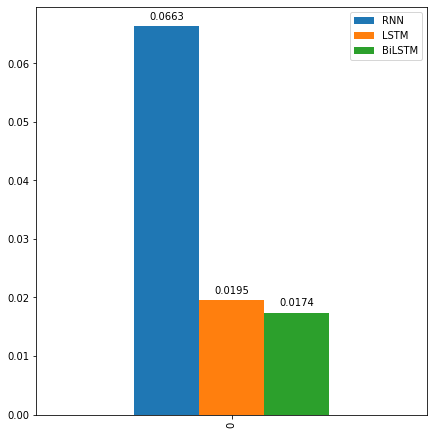

In [ ]:
import matplotlib.pyplot as plt
plot = mae.plot.bar(figsize=(7,7.5))
for p in plot.patches:
    plot.annotate(s=np.round(p.get_height(), decimals=4),
                xy=(p.get_x()+p.get_width()/2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points')

In [ ]:
# make predictions

# invert predictions rnn
y_train_pred_rnn = y_train_pred.clone()
y_train_pred_rnn = scaler.inverse_transform(y_train_pred_rnn.detach().numpy())
y_train_rnn = y_train.clone()
y_train_rnn = scaler.inverse_transform(y_train_rnn.detach().numpy())
y_test_pred_rnn = scaler.inverse_transform(y_test_pred_rnn.detach().numpy())
y_test_rnn= y_test.clone()
y_test_rnn = scaler.inverse_transform(y_test_rnn.detach().numpy())

# # invert predictions lstm
y_train_pred_lstm = y_train_pred.clone()
y_train_pred_lstm = scaler.inverse_transform(y_train_pred_lstm.detach().numpy())
y_train_lstm = y_train.clone()
y_train_lstm = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred_lstm = scaler.inverse_transform(y_test_pred_lstm.detach().numpy())
y_test_lstm = y_test.clone()
y_test_lstm = scaler.inverse_transform(y_test_lstm.detach().numpy())

# invert predictions bilstm
y_train_pred_bilstm = y_train_pred.clone()
y_train_pred_bilstm = scaler.inverse_transform(y_train_pred_bilstm.detach().numpy())
y_train_bilstm = y_train.clone()
y_train_bilstm = scaler.inverse_transform(y_train_bilstm.detach().numpy())
y_test_pred_bilstm = scaler.inverse_transform(y_test_pred_bilstm.detach().numpy())
y_test_bilstm = y_test.clone()
y_test_bilstm = scaler.inverse_transform(y_test_bilstm.detach().numpy())

In [ ]:
rnn = pd.DataFrame({'RNN': y_test_pred_rnn[:, 0]})
lstm = pd.DataFrame({'LSTM': y_test_pred_lstm[:, 0]})
bilstm = pd.DataFrame({'BiLSTM': y_test_pred_bilstm[:, 0]})
df = data.copy()
df = df[-30:]
df = df[['Close']]
df.rename(columns = {'Close':'Actual'}, inplace = True)
df['RNN'] = rnn.values
df['LSTM'] = lstm.values
df['BiLSTM'] = bilstm.values

In [ ]:
df

,Actual,RNN,LSTM,BiLSTM
Date,,,,
2021-08-13,6500.0,5578.750488,6069.722168,6048.738281
2021-08-16,6275.0,5692.059082,6117.977051,6135.308594
2021-08-18,5975.0,5834.568359,6189.409180,6255.499512
2021-08-19,6100.0,5826.260742,6241.155273,6244.121094
2021-08-20,6525.0,5640.636719,6245.843750,6125.912109
2021-08-23,6500.0,5572.696777,6238.945801,6098.914062
2021-08-24,6350.0,5752.792480,6270.142578,6239.370117
2021-08-25,6425.0,5890.821289,6313.788574,6316.384766
2021-08-26,6400.0,5874.806641,6344.770020,6311.990234


In [ ]:
df.to_excel('Pengujian Model RNN, LSTM, BiLSTM.xlsx')

#Plotting Test Result

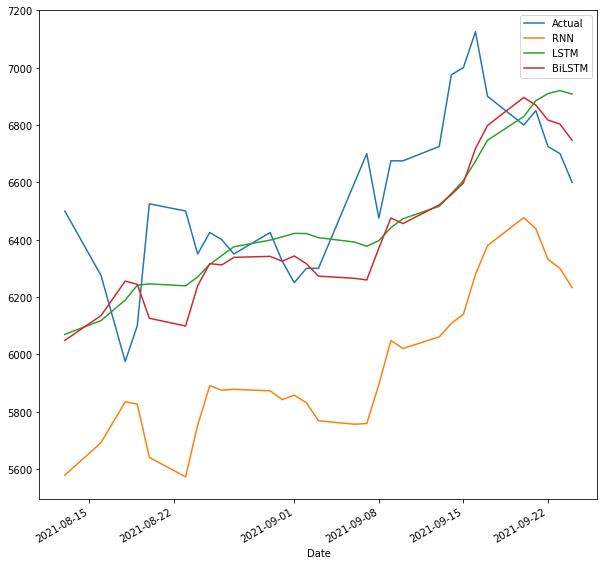

In [ ]:
df.plot(y=["Actual", "RNN","LSTM","BiLSTM"],
        kind="line", figsize=(10, 10),use_index=True)

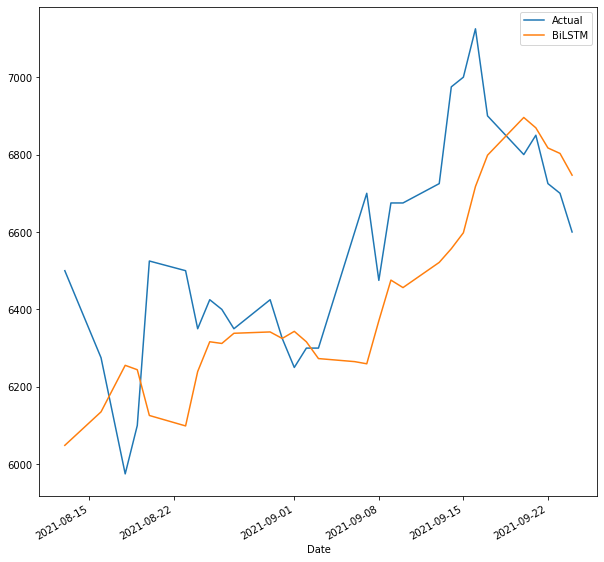

In [ ]:
df.plot(y=["Actual","BiLSTM"],
        kind="line", figsize=(10, 10),use_index=True)